## Clustering with Gamma Ray Burst

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers? (???)
- What variable(s) shows the multi-modality more evidently? (T90)
- Are all GRBs equally likely to be observed? 



#### Python tip. Web request and smarter file reading

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn import preprocessing
from sklearn.cluster import estimate_bandwidth

In [3]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [4]:
# to visualize data
print(data)
print(names)

[['GRB250505A' 'GRB250504B*' 'GRB250504A' ... 'GRB910424A*' 'GRB910423A*'
  'GRB910421A*']
 ['None' 'GRB250504836' 'GRB250504976' ... 'None' 'None' 'None']
 ['8:08:39' '20:03:35.584' '23:25:54' ... '19:43:25.064' '19:51:15.804'
  '9:14:03.800']
 ...
 ['-999' '231.9410' '49.9360' ... '3.1360' '208.5760' '5.6960']
 ['True' 'True' 'False' ... 'False' 'False' 'False']
 ['60800.33934028' '60799.83582852' '60799.97631944' ... '48370.82181787'
  '48369.82726625' '48367.38476620']]
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


## Study of T90 [Short and long RGB]

T90 = Duration of the time interval during which 90% of the GRB photon counts are observed, starting at 5% and ending at 95%. This parameter depends on the efficiency with which photons of various energies can be observed, making the T90 dependent on the detector.

In [5]:
#Pack into python dictionary and convert selected fields to float
grb=dict(zip(names,data))

for lab in ['T90', "redshift","T90_error"]:
    grb[lab] = np.array(grb[lab],dtype='float')

T90 = grb['T90']
redshift = grb['redshift']
T90_error = grb['T90_error']

Text(0.5, 0, 'T90 [s]')

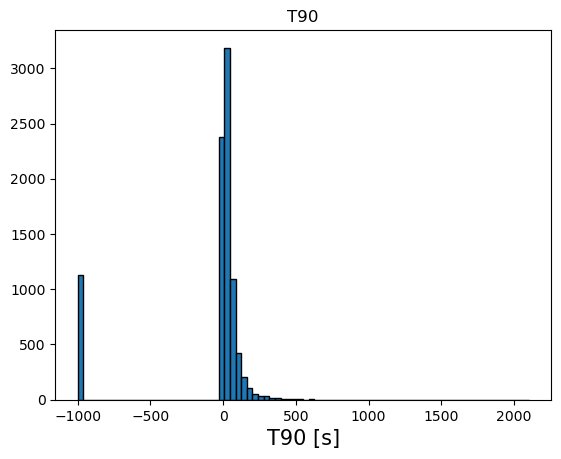

In [6]:
plt.hist(T90, bins=80, label='original data', edgecolor='black')
#plt.hist(grb[T100], bins=50, density=True, label='original data', color = 'b', edgecolor='black')

plt.title('T90')
plt.xlabel('T90 [s]',fontsize=15)


Logaritmic scale to understand data:

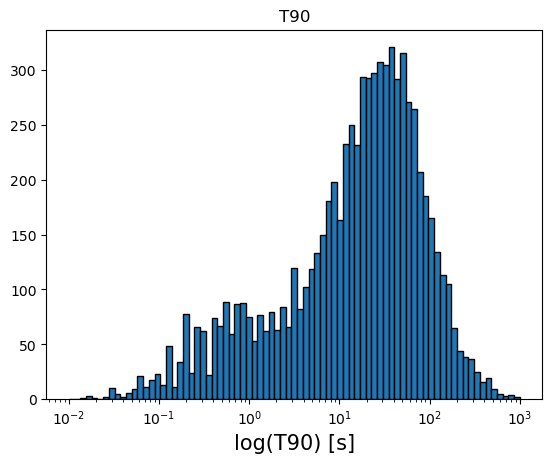

In [7]:
plt.hist(T90, bins=np.logspace(-2,3,80), label='original data', edgecolor='black')
# plt.hist(grb[T100], bins=50, density=True, label='original data', color = 'b', edgecolor='black')

plt.title('T90')
plt.xlabel('log(T90) [s]',fontsize=15)
plt.xscale('log')

### KDE with crossing validation for choosing bandwitdth

In [8]:
T90_positive = T90[ T90>= 0]  # Remove -999 points to don't return nan in the log
T90_log=np.log10(T90_positive)

T90_log

array([2.36345591, 1.68928221, 1.25942663, ..., 0.49637605, 2.31926433,
       0.71466499])

In [9]:
def kde_sklearn(data=grb, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

bwrange = np.linspace(0.01,1.0, 40) # Test 30 bandwidths from 0.1 to 1.0
print(bwrange)
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(T90_log[:, np.newaxis]) # Fit the histogram data that we started the lecture with
h_opt = grid.best_params_['bandwidth']
print(h_opt)

[0.01       0.03538462 0.06076923 0.08615385 0.11153846 0.13692308
 0.16230769 0.18769231 0.21307692 0.23846154 0.26384615 0.28923077
 0.31461538 0.34       0.36538462 0.39076923 0.41615385 0.44153846
 0.46692308 0.49230769 0.51769231 0.54307692 0.56846154 0.59384615
 0.61923077 0.64461538 0.67       0.69538462 0.72076923 0.74615385
 0.77153846 0.79692308 0.82230769 0.84769231 0.87307692 0.89846154
 0.92384615 0.94923077 0.97461538 1.        ]
0.11153846153846153


Text(0.5, 0, 'log(T90) [s]')

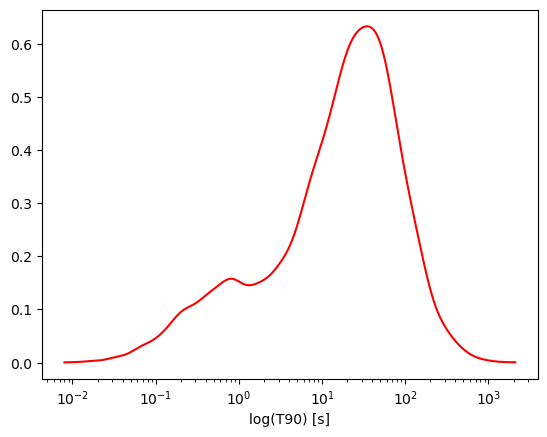

In [10]:
#grid for KDE in log space
xgrid = np.linspace(T90_log.min(), T90_log.max(), 1000)

pdf = kde_sklearn(T90_log, bandwidth=h_opt)
plt.plot(10**xgrid, pdf, c='red'); # return on original scale (not logaritmic, then I do logaritmic)

plt.xscale('log')
plt.xlabel('log(T90) [s]')

I recognize 2 modes (2 peaks)

### Clustering with K-means for log(T90) histogram 

0.7301658049138993


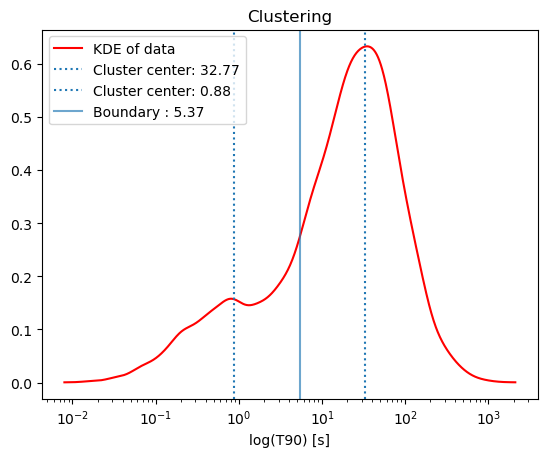

In [11]:
clf = KMeans(n_clusters=2, n_init='auto') #Try 2 clusters to start with
clf.fit(T90_log[:, np.newaxis])
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(T90_log[:, np.newaxis]) #labels for each of the points
boundary = np.mean(centers) # boundary of two clusters
print(boundary)

# plot histo
plt.plot(10**xgrid, pdf, c='red', label = "KDE of data");

# plot centers of clusters
for c in centers:
  cen = 10**c # # For return centers on original scale (not logaritmic)
  plt.axvline(cen, ls='dotted', label=f'Cluster center: {cen[0]:.2f}')

# plot boundary
plt.axvline(10**boundary, label=f'Boundary : {10**boundary:.2f}', alpha = 0.65)

plt.xscale('log')
plt.title('Clustering')
plt.xlabel('log(T90) [s]')
plt.legend()

1° cluster: short GRB  
2° cluster: long GRB

### Clustering with MeanShift for log(T90) histogram 

In [ ]:
b = estimate_bandwidth(T90_log[:, np.newaxis]) 
print('Bandwidth estimated:', b)

scaler = preprocessing.StandardScaler() # To transform values in standardized units, helps clustering algorithms (like MeanShift) perform better:
                                        # Mean of T90_log becomes 0
                                        # Std deviation becomes 1
bandwidth = 0.4
ms = MeanShift(bandwidth=b, bin_seeding=True, cluster_all=False)
ms.fit(scaler.fit_transform(T90_log[:, np.newaxis]))

Bandwidth estimated: 0.5177773128198722


MeanShift(bandwidth=0.5177773128198722, bin_seeding=True, cluster_all=False)


Cluster 1:
Lower edge: 12.00
Center: 49065758480289875681051011973120.00
Upper edge: 83.47

Cluster 2:
Lower edge: 0.32
Center: 6.87
Upper edge: 2.18


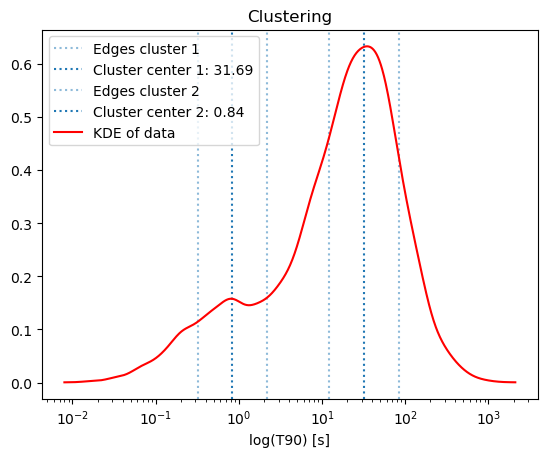

In [13]:
centers_ms = ms.cluster_centers_

# plot centers of clusters and print result
for i,c_ms in enumerate(centers_ms):
  cluster_points = T90_log[ms.labels_ == i]

  c_ms_log = scaler.inverse_transform(c_ms[np.newaxis, :]) # To reverse conversion of StandardScaler
  cen_ms = 10**c_ms_log # return centers on original scale (not logaritmic)

  lower_edge = np.percentile(cluster_points, 0.5)  
  upper_edge = np.percentile(cluster_points, 99.5)
  
  print(f"\nCluster {i+1}:")
  print(f"Lower edge: {10**lower_edge:.2f}")
  print(f"Center: {10**cen_ms[0, 0]:.2f}")
  print(f"Upper edge: {10**upper_edge:.2f}")
    
  plt.axvline(10**lower_edge, ls=':', alpha=0.5, label=f'Edges cluster {i+1}')
  plt.axvline(10**upper_edge, ls=':', alpha=0.5)
  plt.axvline(cen_ms, ls='dotted', label=f'Cluster center {i+1}: {cen_ms[0, 0]:.2f}')


# plot histo
plt.plot(10**xgrid, pdf, c='red', label = "KDE of data");

plt.xscale('log')
plt.xlabel('log(T90) [s]')
plt.title('Clustering')
plt.legend()

Result very close to before

## Study of redshift

Text(0.5, 0, 'Redshift')

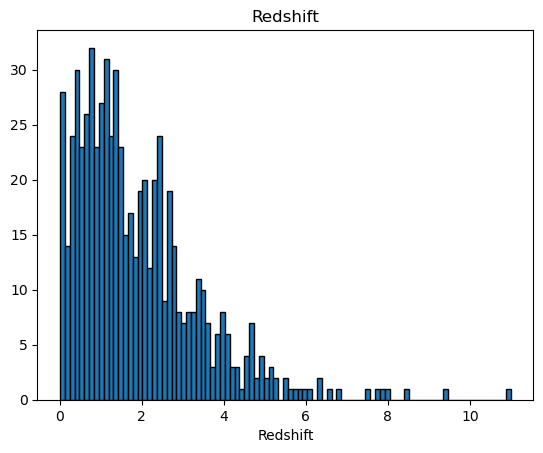

In [14]:
redshift_pos = redshift[redshift>=0]

plt.hist(redshift_pos, bins=int(np.sqrt(len(redshift))), label='original data',  edgecolor='black')
#plt.hist(grb[T100], bins=50, density=True, label='original data', color = 'b', edgecolor='black')

plt.title('Redshift')
plt.xlabel('Redshift')

### KDE with crossing validation for choosing bandwitdth

In [15]:
def kde_sklearn(data=grb, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

bwrange = np.linspace(0.01,1.0, 40) # Test 30 bandwidths from 0.1 to 1.0
print(bwrange)
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(redshift_pos[:, np.newaxis]) # Fit the histogram data that we started the lecture with
h_opt = grid.best_params_['bandwidth']
print(h_opt)

[0.01       0.03538462 0.06076923 0.08615385 0.11153846 0.13692308
 0.16230769 0.18769231 0.21307692 0.23846154 0.26384615 0.28923077
 0.31461538 0.34       0.36538462 0.39076923 0.41615385 0.44153846
 0.46692308 0.49230769 0.51769231 0.54307692 0.56846154 0.59384615
 0.61923077 0.64461538 0.67       0.69538462 0.72076923 0.74615385
 0.77153846 0.79692308 0.82230769 0.84769231 0.87307692 0.89846154
 0.92384615 0.94923077 0.97461538 1.        ]
0.4923076923076923


Text(0.5, 0, 'redshift')

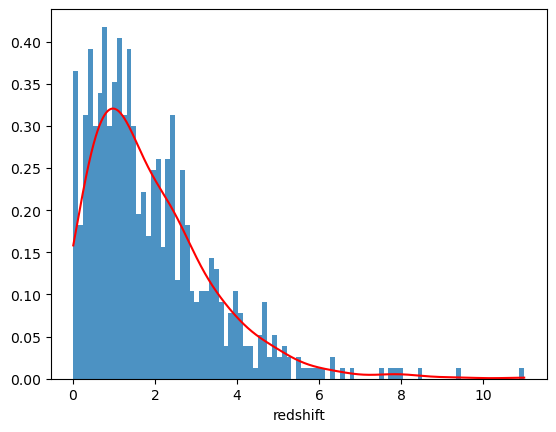

In [16]:
plt.hist(redshift_pos, density=True, bins=int(np.sqrt(len(redshift))), label='original data', alpha=0.8)

#grid for KDE in log space
xgrid = np.linspace(redshift_pos.min(), redshift_pos.max(), 1000)

pdf = kde_sklearn(redshift_pos, bandwidth=h_opt)
plt.plot(xgrid, pdf, c='red'); # return on original scale (not logaritmic, then I do logaritmic)

plt.xlabel('redshift')

not a lot interesting...

#### Consider errors

C:\Users\simon\AppData\Local\Temp\ipykernel_9108\1282297975.py:2: RuntimeWarning: invalid value encountered in log10
  mask_valid = ~np.isnan(np.log10(grb['T90']))


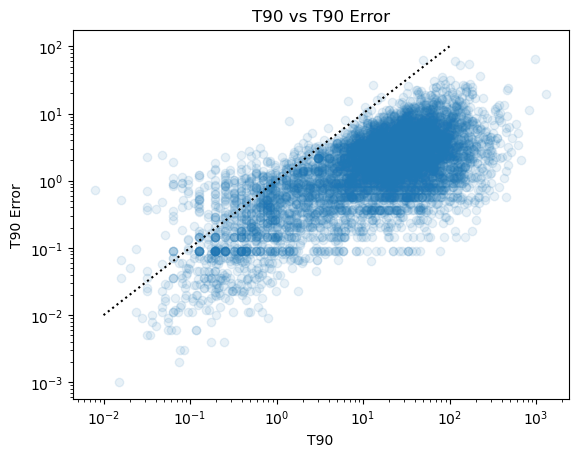

In [17]:
# Filter valid values (T90 > 0 and finite log10)
mask_valid = ~np.isnan(np.log10(grb['T90']))
times = grb['T90'][mask_valid]
errortimes = grb['T90_error'][mask_valid]

# Filter out clearly invalid error values (e.g., placeholder -10)
mask_error = errortimes > -10
times = times[mask_error]
errortimes = errortimes[mask_error]

# Scatter plot of T90 values vs. their errors
plt.scatter(times, errortimes, alpha=0.1)

# Reference line y = x
plt.plot([1e-2, 1e2], [1e-2, 1e2], c='black', ls='dotted')

# Set log-log scale
plt.loglog()

# Axis labels
plt.xlabel('T90')
plt.ylabel('T90 Error')
plt.title('T90 vs T90 Error')
plt.show()


The dotted black line represents y = x. Points below this line indicate measurements where the error is smaller than the value itself — this is the desired regime. Most points fall below this line, which justifies neglecting the errors in further analysis.

However, some points — particularly at the lower end of T90 — approach or even exceed the line. This indicates that for short-duration bursts, the errors can be comparable to the measurement, suggesting potential bias or unreliability.

#### Redshift vs T90 

I print centers calculated before with MeanShift

C:\Users\simon\AppData\Local\Temp\ipykernel_9108\713000775.py:2: RuntimeWarning: invalid value encountered in log10
  T90_new = grb['T90'][~np.isnan(np.log10(grb['T90']))]
C:\Users\simon\AppData\Local\Temp\ipykernel_9108\713000775.py:3: RuntimeWarning: invalid value encountered in log10
  redshift_new = grb['redshift'][~np.isnan(np.log10(grb['T90']))]


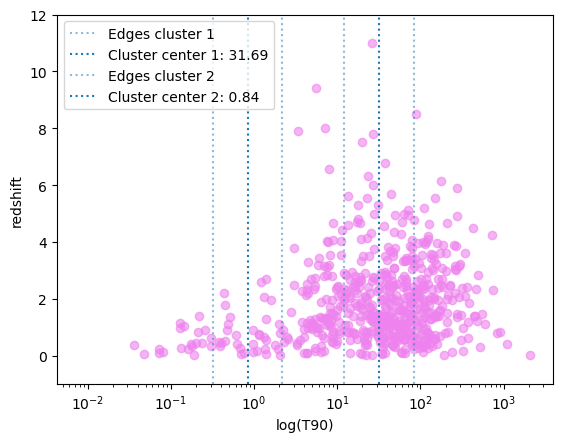

In [18]:
# selecting T90 and redshift values from df_subset where both T90 > 0
T90_new = grb['T90'][~np.isnan(np.log10(grb['T90']))]
redshift_new = grb['redshift'][~np.isnan(np.log10(grb['T90']))]

plt.scatter(T90_new , redshift_new, color = 'violet', alpha=0.6)

# plot centers of clusters and print result
for i,c_ms in enumerate(centers_ms):
  cluster_points = T90_log[ms.labels_ == i]

  c_ms_log = scaler.inverse_transform(c_ms[np.newaxis, :]) # To reverse conversion of StandardScaler
  cen_ms = 10**c_ms_log # return centers on original scale (not logaritmic)
  
  lower_edge = np.percentile(cluster_points, 0.5)  
  upper_edge = np.percentile(cluster_points, 99.5)

  plt.axvline(10**lower_edge, ls=':', alpha=0.5, label=f'Edges cluster {i+1}')
  plt.axvline(10**upper_edge, ls=':', alpha=0.5)
  plt.axvline(cen_ms, ls='dotted', label=f'Cluster center {i+1}: {cen_ms[0, 0]:.2f}')

plt.ylabel('redshift')
plt.xlabel('log(T90)')
plt.ylim(-1,redshift.max()+1)
plt.semilogx()
plt.legend()

Long GRBs are far (en fact they come from supernovae, young stars)  
Short GRBs are close (en fact they come from neutron-star mergers, old stars).

DO PCA AND SEE IF U SEE SOMETHING NOTICEABLE